# Multi Digit Number Recognition with SVHN

This notebook implements multi digit number recognition using SVHN dataset that will be used to recognize house numbers at the streets. It can be considered as second version of the previous multi digit recognition which uses MNIST database. Keras and Tensorflow libraries are used to build the recognizer.
This recognizer extracts digit from the image using Convolutional Neural Network Classifier.

In [31]:

import random

import numpy as np
import tensorflow as tf
import h5py
from tensorflow.keras import utils

from six.moves import range

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.color import rgb2gray

In [2]:
# Setting the random seed so that the results are reproducible. 
random.seed(42)

## Load Dataset

In [4]:
filename = 'data/SVHN_multi_grey.h5'

data = h5py.File(filename, 'r')
train_dataset = np.array(data["train_dataset"])
train_labels = np.array(data["train_labels"])
test_dataset = np.array(data["test_dataset"])
test_labels = np.array(data["test_labels"])
valid_dataset = np.array(data["valid_dataset"])
valid_labels = np.array(data["valid_labels"])

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (27401, 64, 64, 1) (27401, 5)
Validation set (3000, 64, 64, 1) (3000, 5)
Test set (13068, 64, 64, 1) (13068, 5)


Label for image: [ 2  6 10 10 10]


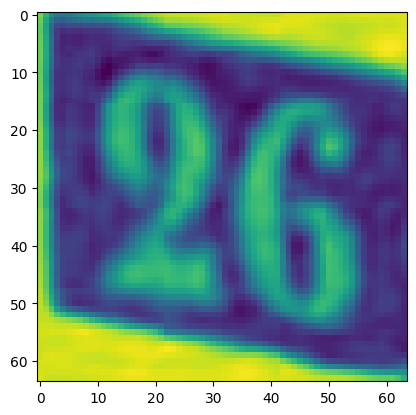

In [5]:
plt.figure()
plt.imshow(train_dataset[70])

print(f"Label for image: {train_labels[70]}")

## Convert Labels
This function converts each digit label to one-hot array.

In [6]:
# Converting labels to One-hot representations of shape (set_size, digits, classes)
possible_classes = 11

def convert_labels(labels):
    
    # As per Keras conventions, the multiple labels need to be of the form [array_digit1,...5]
    # Each digit array will be of shape (60000,11)
        
    # Declare output ndarrays
    # 5 for digits, 11 for possible classes  
    dig0_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig1_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig2_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig3_arr = np.ndarray(shape=(len(labels),possible_classes))
    dig4_arr = np.ndarray(shape=(len(labels),possible_classes))
    
    for index,label in enumerate(labels):
        
        # Using utils.np_utils from keras to OHE the labels in the image
        dig0_arr[index,:] = utils.to_categorical(label[0],possible_classes)
        dig1_arr[index,:] = utils.to_categorical(label[1],possible_classes)
        dig2_arr[index,:] = utils.to_categorical(label[2],possible_classes)
        dig3_arr[index,:] = utils.to_categorical(label[3],possible_classes)
        dig4_arr[index,:] = utils.to_categorical(label[4],possible_classes)
        
    return [dig0_arr,dig1_arr,dig2_arr,dig3_arr,dig4_arr]

In [7]:
train_labels = convert_labels(train_labels)
test_labels = convert_labels(test_labels)
valid_labels = convert_labels(valid_labels)

In [8]:
# Checking the shape of the OHE array for the first digit position
np.shape(train_labels[0])

(27401, 11)

## Prepare Data for Keras
Reshape image data to be processed by Keras.

In [9]:
def prep_data_keras(img_data):
    
    # Reshaping data for keras, with tensorflow as backend
    img_data = img_data.reshape(len(img_data), 64, 64, 1)
    
    # Converting everything to floats
    img_data = img_data.astype('float32')
    
    # Normalizing values between 0 and 1
    #img_data /= 255
    
    return img_data


In [10]:
train_images = prep_data_keras(train_dataset)
test_images = prep_data_keras(test_dataset)
valid_images = prep_data_keras(valid_dataset)

In [11]:
np.shape(train_images)

(27401, 64, 64, 1)

In [12]:
np.shape(test_images)

(13068, 64, 64, 1)

In [31]:
64*64

4096

In [13]:
# Importing relevant keras modules
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard


## Build Model
Build Deep Learning model to process data.

In [14]:
train_images_reshaped = np.reshape(train_images, (train_images.shape[0],64*64))
test_images_reshaped = np.reshape(test_images, (test_images.shape[0],64*64))
valid_images_reshaped = np.reshape(valid_images, (valid_images.shape[0],64*64))

In [15]:
train_images_reshaped.shape

(27401, 4096)

In [16]:
# Building the model

batch_size = 128
nb_classes = 11
# nb_epoch = 24
nb_epoch = 10

# image input dimensions
img_rows = 64
img_cols = 64
img_channels = 1

inputs = Input(shape=(4096))

x = Dense(1024, activation="relu")(inputs)
x = Dense(256, activation="relu")(x)
x = Dense(64, activation="relu")(x)


# Prediction layers
c0 = Dense(nb_classes, activation='softmax')(x)
c1 = Dense(nb_classes, activation='softmax')(x)
c2 = Dense(nb_classes, activation='softmax')(x)
c3 = Dense(nb_classes, activation='softmax')(x)
c4 = Dense(nb_classes, activation='softmax')(x)

# Defining the model
model = Model(inputs=inputs,outputs=[c0,c1,c2,c3,c4])
print (model.summary())


# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
    
# Fitting the model
model.fit(train_images_reshaped,train_labels,batch_size=batch_size,epochs=nb_epoch,verbose=1,
          validation_data=(valid_images_reshaped, valid_labels), callbacks=[early_stopping])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         4195328     ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          262400      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 64)           16448       ['dense_1[0][0]']                
                                                                                              

215/215 [==============================] - 18s 82ms/step - loss: 5.4388 - dense_3_loss: 1.9215 - dense_4_loss: 2.1902 - dense_5_loss: 1.0768 - dense_6_loss: 0.2476 - dense_7_loss: 0.0028 - dense_3_accuracy: 0.3155 - dense_4_accuracy: 0.2240 - dense_5_accuracy: 0.7000 - dense_6_accuracy: 0.9578 - dense_7_accuracy: 0.9997 - val_loss: 5.4323 - val_dense_3_loss: 1.9157 - val_dense_4_loss: 2.1591 - val_dense_5_loss: 1.0915 - val_dense_6_loss: 0.2653 - val_dense_7_loss: 7.0533e-04 - val_dense_3_accuracy: 0.3080 - val_dense_4_accuracy: 0.2373 - val_dense_5_accuracy: 0.6933 - val_dense_6_accuracy: 0.9540 - val_dense_7_accuracy: 1.0000


In [17]:
predictions = model.predict(test_images_reshaped)

409/409 [==============================] - 4s 9ms/step


In [18]:
np.shape(predictions)

(5, 13068, 11)

In [19]:
model.save('saved_model/ffnn_model')
# new_model = tf.keras.models.load_model('saved_model/cnn_model')
# new_model.summary()

INFO:tensorflow:Assets written to: saved_model/ffnn_model\assets


INFO:tensorflow:Assets written to: saved_model/ffnn_model\assets


## Calculate Accuracy
Custom accuracy calculation for individual digits and the whole sequence.

In [20]:
def calculate_acc(predictions,real_labels):
    
    individual_counter = 0
    global_sequence_counter = 0
    coverage_counter = 0
    confidence = 0.7
    for i in range(0,len(predictions[0])):
        # Reset sequence counter at the start of each image
        sequence_counter = 0 
        
        for j in range(0,5):
            
            if np.argmax(predictions[j][i]) == np.argmax(real_labels[j][i]):
                individual_counter += 1
                sequence_counter += 1
            if predictions[j][i][np.argmax(predictions[j][i])] >= confidence:
                coverage_counter += 1
        
        if sequence_counter == 5:
            global_sequence_counter += 1
         
    ind_accuracy = individual_counter / float(len(predictions[0]) * 5)
    global_accuracy = global_sequence_counter / float(len(predictions[0]))
    coverage = coverage_counter / float(len(predictions[0]) * 5)
    
    return ind_accuracy,global_accuracy, coverage

In [21]:
ind_acc, glob_acc, coverage = calculate_acc(predictions, test_labels)

In [22]:
print("The individual accuracy is {} %".format(ind_acc * 100))
print("The sequence prediction accuracy is {} %".format(glob_acc * 100))
print("The coverage is {} %".format(coverage * 100))

The individual accuracy is 67.99510254055708 %
The sequence prediction accuracy is 4.5531068258340985 %
The coverage is 53.03183348637894 %


In [53]:
def rgb2gray(images):
    """Convert images from rbg to grayscale
    """
    greyscale = np.dot(images, [0.2989, 0.5870, 0.1140])
    return np.expand_dims(greyscale, axis=2)

In [36]:
# img = input()
img = "data/img_1.jpg"
image = Image.open(img)
image_size = (64, 64)
resize_img = np.array(image.resize((image_size[0], image_size[1]), Image.ANTIALIAS))
grey_img = rgb2gray(resize_img[:,:,:3]).astype(np.float32)
expanded_img = np.expand_dims(grey_img, axis=0)
expanded_img_1 = np.reshape(prep_data_keras(expanded_img), (1,64*64))


C:\Users\abhi\AppData\Local\Temp\ipykernel_7692\2563138490.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resize_img = np.array(image.resize((image_size[0], image_size[1]), Image.ANTIALIAS))


In [37]:
expanded_img_1.shape

(1, 4096)

In [38]:
predictions = model.predict(expanded_img_1)

1/1 [==============================] - 0s 28ms/step


In [39]:
predicted_digits = ""
for i in range(5):
    digit = np.argmax(predictions[i][0])
    predicted_digits += str(digit) + " " if digit != 10 else ""
print(f'The predicted number sequence: {predicted_digits.strip(" ")}')

The predicted number sequence: 1


In [ ]:
# Printing some examples of real and predicted labels
for i in random.sample(range(0,10000),5):
    
    actual_labels = []
    predicted_labels = []
    plt.figure()
    plt.imshow(test_dataset[i])
    for j in range(0,5):
        actual_labels.append(np.argmax(test_labels[j][i]))
        predicted_labels.append(np.argmax(predictions[j][i]))
        
    print("Actual labels: {}".format(actual_labels))
    print("Predicted labels: {}\n".format(predicted_labels))